# Further analysing data

In order to analyse data we use different libraries (e.g. statsmodels, scikit-learn,...) with its various regressions- (and clustering-)algorithms.

* calculate rolling means (moving averages)
* resample time series data by the month, week, year, etc. (if needed)
* diving into stationarity, trends, seasonality, first-order differencing, and autocorrelation
* cross-validation


### Importing libraries and data

In [1]:
import csv
import pandas as pd
import numpy as np
import time

# Set global variables
g_len_list = 10 # variable to show no of records in various steps
debug = 0 # for all (1) OR condensed output (0)

###### INPUTS
path = 'S:/Andreas/FH/Technikum/BA/'  #including slash at the end!
get = '50_Datasets/'

filename = 'df_cs_90864.csv'
delimiter = ','
###### ######

if debug:
    start_time = time.time()

# 01 Import data from csv
print(f'> Fetching data...')
data = csv.DictReader(open(path+get+filename, encoding="ISO8859"), delimiter=delimiter)
df = pd.DataFrame(data)
# Explicitly convert the date column to type DATETIME
df['UTC'] = pd.to_datetime(df['UTC']) #, utc=True)
# All other columns make numbers
for col in df.columns:
    if not 'UTC' in col:
        df[col] = pd.to_numeric(df[col])

# Set date column as index
'''
df = df.set_index(pd.DatetimeIndex(df['UTC']))
df.sort_index(inplace=True)
df = df.asfreq(freq='10min') #when upsampling do a fill with specific value: df.asfreq(freq='30S', method='ffill')
# check the indices
df.index
'''
print(f'> {len(df.index)} lines into DF imported')

# 02 Make df smaller
print(f'\n> Deleting unnecessary columns...')
#df.drop(list(df.filter(regex = '_FLAG')), axis = 1, inplace = True) #without copy
print(f'...done')
if debug:
    print(f'> Script finished after running %.2f seconds.' % (time.time() - start_time))

# 03 Show data
'''
fig, ax = plt.subplots(figsize=(16,11))
ax.plot(df['UTC'])
ax.set_xlabel('Time')
'''

if debug:
    print(df.tail())
df.info()

> Fetching data...
> 90864 lines into DF imported

> Deleting unnecessary columns...
...done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90864 entries, 0 to 90863
Data columns (total 40 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   UTC        90864 non-null  datetime64[ns]
 1   BA_T       90864 non-null  float64       
 2   CC_T       90864 non-null  float64       
 3   CR_T       90864 non-null  float64       
 4   DR_T       90864 non-null  float64       
 5   HB_T       90864 non-null  float64       
 6   HF_T       90864 non-null  float64       
 7   KE_T       90864 non-null  float64       
 8   KW_T       90864 non-null  float64       
 9   LA_T       90864 non-null  float64       
 10  LR_T       90864 non-null  float64       
 11  OA_time    90864 non-null  int64         
 12  OA_DD      90864 non-null  float64       
 13  OA_FFAM    90864 non-null  float64       
 14  OA_FFX     90864 non-null  float64       

### (optional) For creating visuals...

##### ...start with defining defaults.

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

#plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 6]
#%matplotlib inline

### Step 09

### Calculate simple moving averages

Data is available in 10mins intervals. So for yearly seasonality *6(h)*24(d)*365,25(yr) = 52596 periods are to be taken into account.\
As sometimes 30mins intervals are resampled to 10mins before analysis also a period of 17532 might be of interest.

For subsets other periods are used:
* Cold Season (3 Months): 12960 for 90 days, 13149 for 91.3125 days (a quarter of a year considering leapyears: 365.25)

> Calculation of different (rolling) means:


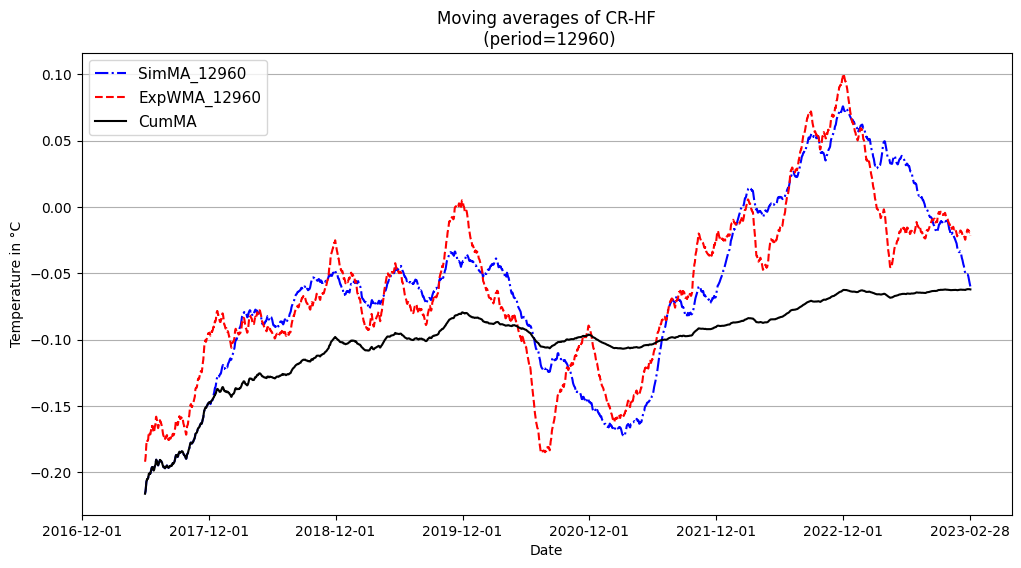

In [142]:
# Define column to analyse and periodicity
###### INPUTS
c = 25
period = 12960  #period = 52596  #period=17532 #10mins intervall data=1 *6(h)*24(d)*365,25(yr) = 52596 to get yearly data
###### ######

# Calculating means 
print(f'> Calculation of different (rolling) means:')

cn = df.iloc[:, c].name

# Updating dataframe to have only one column, as rest of columns are of no use at the moment 
# Using .to_frame() to convert pandas series into dataframe
df_short = df[cn].to_frame()
# Add date column and set date as index
df_short['DateIndex'] = df.iloc[:, 0]
#df_short.set_index('DateIndex', inplace=True)

# Calculating simple moving average using .rolling().mean()
sma = 'SimMA_'+str(period)
df_short[sma] = df_short.iloc[:, 0].rolling(period, min_periods=(period//2)).mean()  #rolling(window = period, center = True).mean()

# Calculating exponential moving average using .ewm(span).mean() , with window size = period
ewma = 'ExpWMA_'+str(period)
df_short[ewma] = df_short.iloc[:, 0].ewm(span=period, min_periods=(period//2)).mean()

# Try different periods
ewma2 = 'EWMA_'+str(period/2)
df_short[ewma2] = df_short.iloc[:, 0].ewm(span=period/2).mean()

ewma3 = 'EWMA_'+str(period*2)
df_short[ewma3] = df_short.iloc[:, 0].ewm(span=period*2).mean()

# Calculating cumulative moving average using .expanding().mean()
# Cumulative moving average considers all prior observations, no dropping of oldest observations
cma = 'CumMA'
df_short[cma] = df_short.iloc[:, 0].expanding(min_periods=(period//2)).mean()

# Format and resize values for x-axis
range = pd.Series(df.iloc[:, 0]).apply(lambda x: "{:%Y-%m-%d}".format(x)) #.format("%Y-%m-%d")
range_short = range[0::12980]
x_labels = ['2016-12-01', '2017-12-01','2018-12-01','2019-12-01','2020-12-01','2021-12-01','2022-12-01','2023-02-28']

# Plotting various moving averages
title = 'Moving averages of '+cn.replace(r'_n', '')+'\n (period='+str(period)+')'
styles = ['b-.','r--','k-'] #colorblind checked
fig = df_short[[sma, ewma, cma]].plot(title=title, style=styles) #cmap="winter") #prism

fig.set_xlabel('Date')
fig.set_ylabel('Temperature in °C')
fig.set_xticks(range_short.index)
fig.set_xticklabels(x_labels)
fig.legend(fontsize='11')
plt.grid(axis = 'y')

### (optional) Linear regression - Simple (linear) trend

In [13]:
from scipy.stats import linregress

# linregress cannot work with dates, therefore the timestamp "number" is used
x = pd.to_numeric(df['OA_time'].iloc[6480:,])
#x = np.arange(0,len(df)) #create simple number index artificially

df[df.iloc[:, c].name] = pd.to_numeric(df.iloc[:, c])
y = df_short[cma].iloc[6480:,]

print(f'> Simple trend analysis of '+cn)
res = linregress(x, y)
print(f'Equation: {res[0]:.3f} * t + {res[1]:.3f}, R^2: {res[2] ** 2:.2f} ')
print(res)

> Simple trend analysis of CR-HF
Equation: 0.000 * t + -0.814, R^2: 0.71 
LinregressResult(slope=4.493929379760335e-19, intercept=-0.8137046806184662, rvalue=0.8450136753916756, pvalue=0.0, stderr=9.790031361423441e-22, intercept_stderr=0.0015542796755877654)


### (optional) Visualize Linear regression (on CumMA)

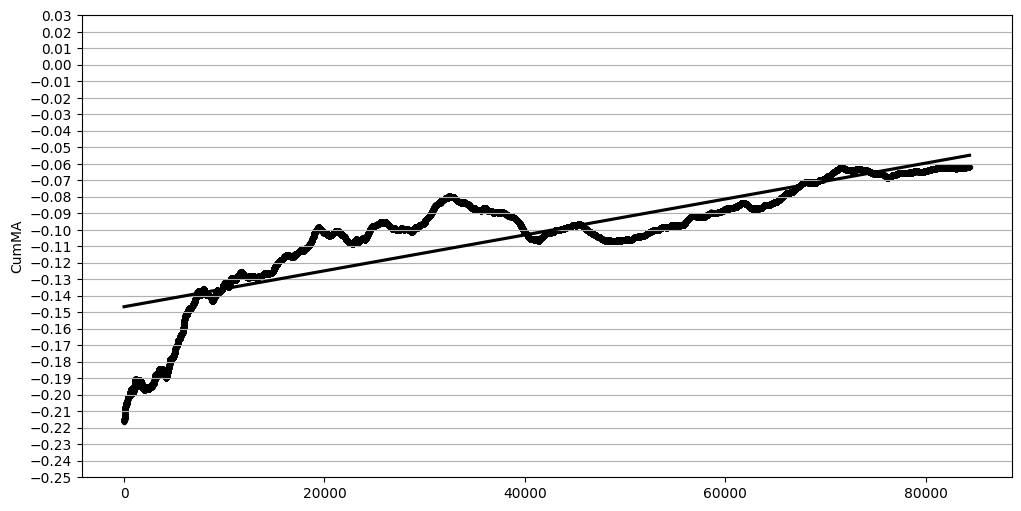

In [19]:
x = np.linspace(0,84384,84384)
sns.regplot(data = df_short,
            x = x,
            y = y,
            color = 'black',
            #y_jitter = 0.001,
            marker = '.',
            ci = 99.99);   
plt.yticks(np.arange(-.25, .03, step=0.01), minor=False);
plt.grid(axis='y')

### (optional) Polynomial regression

In [15]:
print(f'> Polynomial trend analysis of '+cn)
print(f'Polyfit_1:')
z = np.polyfit(x,y,1) # number is degree
print("{0}x + {1}".format(*z))
print(f'Polyfit_2:')
z = np.polyfit(x,y,2)
print("{0}x^2 + {1}x + {2}".format(*z))

> Polynomial trend analysis of CR-HF
Polyfit_1:
1.0877267891690795e-06x + -0.14663299840833569
Polyfit_2:
-1.5820694104957054e-11x^2 + 2.422740240521782e-06x + -0.16540840508328164


### Step 10
### Time Series Decomposition (basic)

> Quick (partial) autocorrelation test of CR-HF


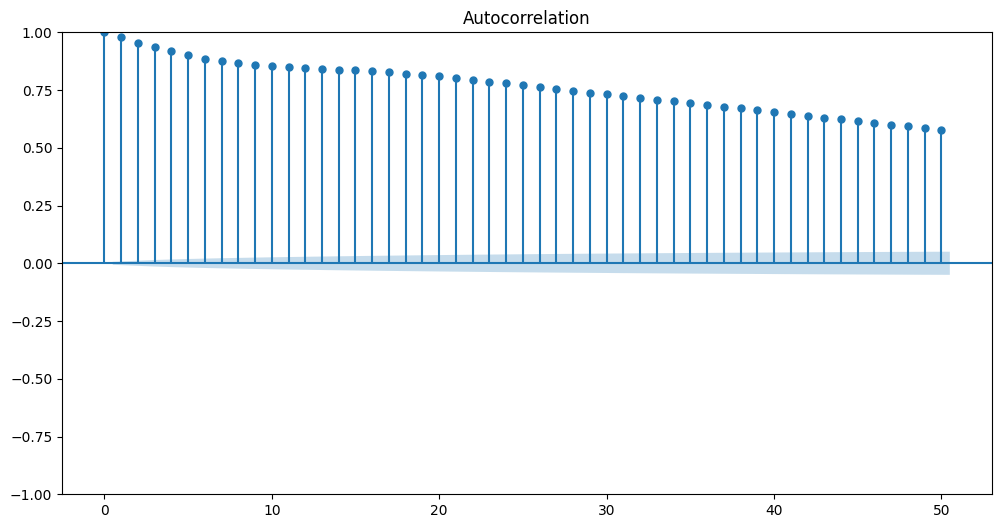

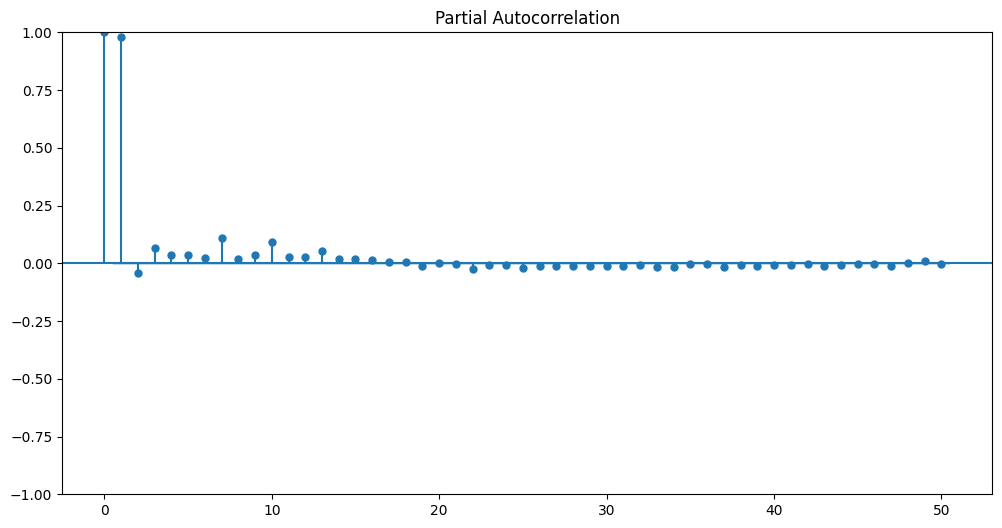


> Performing seasonal decomposition of CR-HF


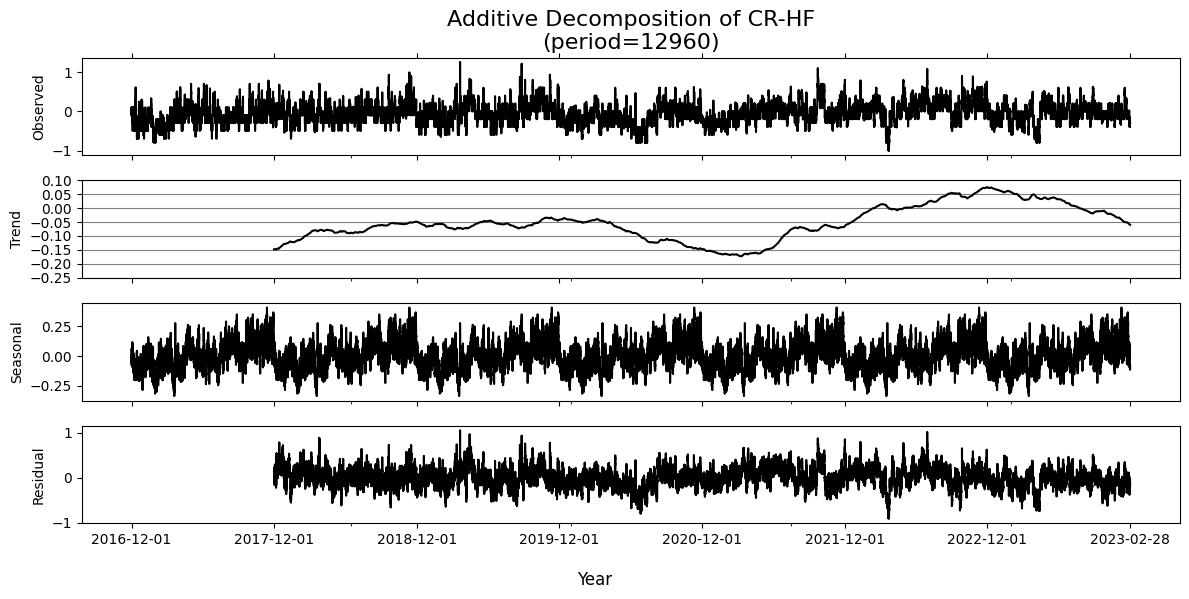

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate autocorrelation and partial autocorrelation
print(f'> Quick (partial) autocorrelation test of '+cn+' (1st 50)')
plot_acf(df.iloc[:, c], lags=50)
plot_pacf(df.iloc[:, c], lags=50)
plt.show()

#x = pacf(df['Diff'], method='ywunbiased', alpha=None)


from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Calculate seasonal decomposition
print(f'\n> Performing seasonal decomposition of '+cn)

# Multiplicative Decomposition 
#multiplicative_decomposition = seasonal_decompose(df['Diff'], model='multiplicative', period=period)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df[cn], model='additive', period=period, two_sided=False) 

# Plot subgraphs
res = additive_decomposition
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False, style='k')
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, style='k')
    axes[1].set_ylabel('Trend')
    axes[1].yaxis.grid(True, color ="grey")
    axes[1].yaxis.set_ticks(np.arange(-0.25, 0.15, 0.05))
    res.seasonal.plot(ax=axes[2], legend=False, style='k')
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, style='k')
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True)
range = pd.Series(df.iloc[:, 0]).apply(lambda x: "{:%Y-%m-%d}".format(x)) #.format("%Y-%m-%d")
range_short = range[0::12980]
x_labels = ['2016-12-01', '2017-12-01','2018-12-01','2019-12-01','2020-12-01','2021-12-01','2022-12-01','2023-02-28']
axes[0].tick_params('x', reset=True)
axes[0].set_xticks(range_short.index)
axes[0].set_xticklabels(x_labels, rotation = 45)
axes[0].set_title('Additive Decomposition of '+cn.replace(r'_n', '')+'\n(period='+str(period)+')', fontsize=16)
fig.supxlabel('Year')
plotseasonal(res, axes)
plt.tight_layout()
plt.show()


(optional) Create graph with linear trend line

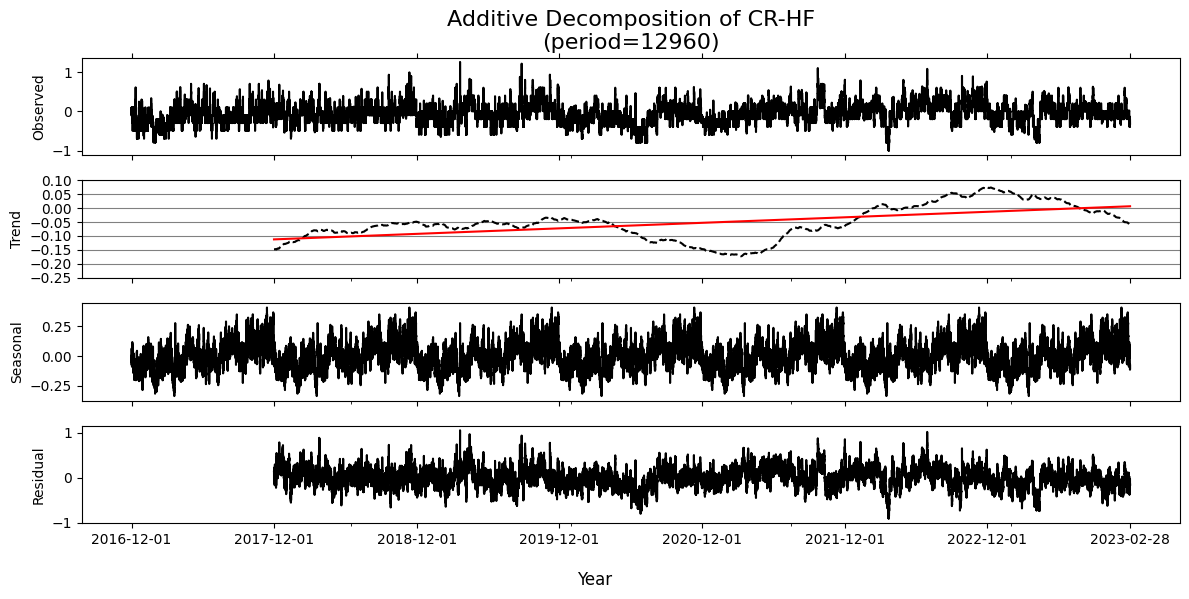

In [143]:
# Calculate linear regression (LSR)
d = res.trend
d = d[d.isna() == False]

# Reduced dataframe to match res.trend
x = np.linspace(12960,90864,77904) 

slope, intercept, r_value, p_value, std_err = linregress(x, d)

# Plot subgraphs
def plotseasonal_2(res, axes ):
    res.observed.plot(ax=axes[0], legend=False, style='k')
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False, style='k', linestyle='--')
    # add trend line
    axes[1].plot(x, intercept + slope*x, 'r')  #plt.plot(x, intercept + slope*x, 'r', label='fitted line')
    
    axes[1].set_ylabel('Trend')
    axes[1].yaxis.grid(True, color ="grey")
    axes[1].yaxis.set_ticks(np.arange(-0.25, 0.15, 0.05))
    res.seasonal.plot(ax=axes[2], legend=False, style='k')
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False, style='k')
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True)
range = pd.Series(df.iloc[:, 0]).apply(lambda x: "{:%Y-%m-%d}".format(x)) #.format("%Y-%m-%d")
range_short = range[0::12980]
x_labels = ['2016-12-01', '2017-12-01','2018-12-01','2019-12-01','2020-12-01','2021-12-01','2022-12-01','2023-02-28']
axes[0].tick_params('x', reset=True)
axes[0].set_xticks(range_short.index)
axes[0].set_xticklabels(x_labels, rotation = 45)
axes[0].set_title('Additive Decomposition of '+cn.replace(r'_n', '')+'\n(period='+str(period)+')', fontsize=16)
fig.supxlabel('Year')
plotseasonal_2(res, axes)
plt.tight_layout()
plt.show()

### Time Series Decomposition (advanced)

STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships.

In [ ]:
from statsmodels.tsa.seasonal import STL

#period = 12960

print(f'> Performing STL decomposition of '+cn)
start_time = time.time()
stl_decomposition = STL(df[cn], period=period).fit()
print(f'\n> Script finished after running %.2f seconds.' % (time.time() - start_time))

# Own graph
res = stl_decomposition
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True)
range = pd.Series(df.iloc[:, 0]).apply(lambda x: "{:%Y-%m-%d}".format(x)) #.format("%Y-%m-%d")
range_short = range[0::12980]
x_labels = ['2016-12-01', '2017-12-01','2018-12-01','2019-12-01','2020-12-01','2021-12-01','2022-12-01','2023-02-28']
axes[0].tick_params('x', reset=True)
axes[0].set_xticks(range_short.index)
axes[0].set_xticklabels(x_labels, rotation = 45)
axes[0].set_title('Additive Decomposition of '+cn.replace(r'_n', '')+' (period='+str(period)+')', fontsize=16)
fig.supxlabel('Year')
plotseasonal(res, axes) # Call function
plt.tight_layout()
plt.show()

### Step 11

### Further analyses - #1 Stationarity

A stationary time series means that the manner in which time series data changes is constant - no trend or seasonal patterns.
* Method: (augmented) Dickey Fuller test 
* P-Value and Test Statistics important 
* Null hypothesis that there is non-stationarity

In general: Non-stationary data (accepting the null hypothesis) when:
* p-value is greater than 5 percent
* test statistic is greater than the critical value

In [30]:
from statsmodels.tsa.stattools import adfuller

print(f'> Performing test for stationarity of '+cn)
adft = adfuller(df_short,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used", 
                                                        "Number of observations used","critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -1.867361e+01              Test Statistics
1  2.043947e-30                      p-value
2  6.600000e+01             No. of lags used
3  9.079700e+04  Number of observations used
4 -3.430422e+00          critical value (1%)
5 -2.861572e+00          critical value (5%)
6 -2.566787e+00         critical value (10%)


##### Result of stationarity
CR-HF:
* p-value very low (basically 0) --> stationary
* Test statistic -18,6 is lower that -3.4  --> stationary

### Further analyses - #2 Autocorrelation

Autocorrelation can help identify seasonal patterns in a time series.

> Performing test for potentially finding seasonality of CR-HF


<Axes: title={'center': 'Autocorrelation of CR-HF\n(period=12960)'}, xlabel='Lag', ylabel='Autocorrelation'>

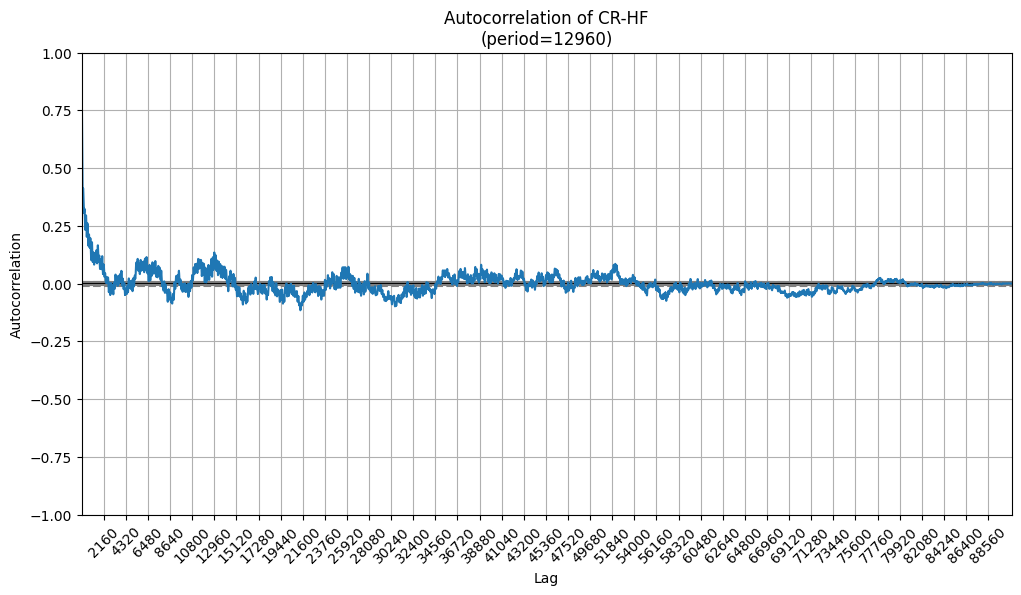

In [32]:
from pandas.plotting import autocorrelation_plot

#period = 12960

# Testing for seasonality
print(f'> Performing test for potentially finding seasonality of '+cn)

df_short = df[cn].astype(float)
s = pd.Series(df_short)

# Plot results
plt.xticks(np.arange(0, period*7, step=period/6), rotation = 45)
plt.title('Autocorrelation of '+cn+'\n(period='+str(period)+')', fontsize=12)
autocorrelation_plot(s)

### (optional) Addon - Outdoor temperature dependency 

Creation of visuals for checking indoor vs. outdoor temperature dependency

##### Visual 1

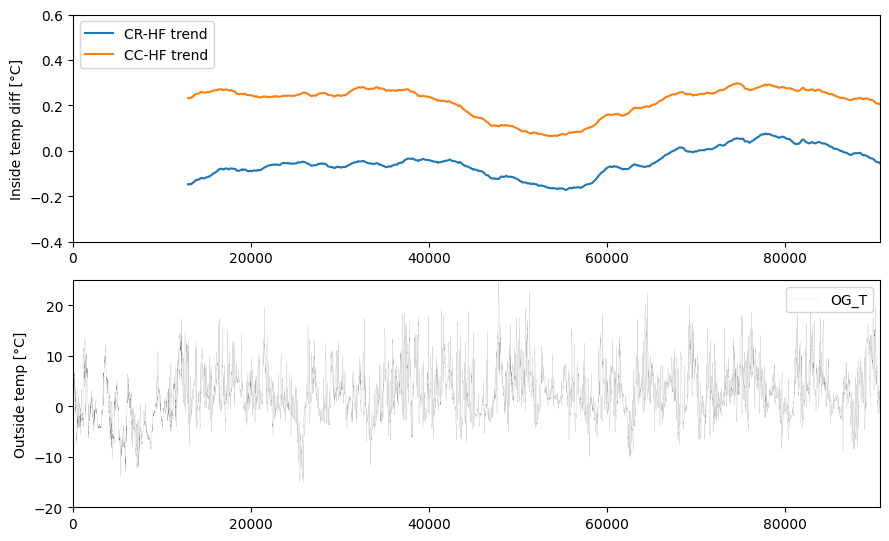

In [50]:
# Define temp difference to look at for graphs
a1 = additive_decomposition.trend

# Define another temp difference to look at for graphs
attr = 'CC-HF'
additive_decomposition_2 = seasonal_decompose(df[attr], model='additive', period=period, two_sided=False) 
a2 = additive_decomposition_2.trend

# Define attribute to compare to
df['OG_T'] = df['OG_T'].astype(float)
b = df['OG_T'] 

# Define common features for figure (x-axis)
fig, (ax1, ax2) = plt.subplots(2, figsize=(9,6))
xs = df.index

# Plot inside temp differences
ax1.plot(xs, a1, label=cn + ' ' + a1.name)
ax1.plot(xs, a2, label=attr + ' ' + a2.name)
ax1.set_xlim(0, period*7)
ax1.set_ylim(-0.4, +0.6)
ax1.set_ylabel('Inside temp diff [°C]')
ax1.legend(loc='upper left')

# Plot comparison attribute
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'black'
linewidth = 0.05
ax2.plot(xs, b, color=color, linewidth=linewidth, label=b.name)
ax2.set_xlim(0, period*7)
ax2.set_ylim(-20, +25)
#ax2.set_yticks(np.arange(-20, +25, step=5))
ax2.set_ylabel('Outside temp [°C]')
ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.show()

##### Visual 2
Scatter Plot: Any linear dependency of the inside temperature difference to outside temperatures is not visible...

In [ ]:
# Create scatter plot
x = df['OG_T']
y = df[cn] 
z = df['UTC'].dt.year
fg = plt.scatter(x, y, c=z, s=5, marker='.')
plt.xlabel('Outside temperature in °C')
plt.ylabel(y.name+' in °C')
plt.legend(*fg.legend_elements(), title='Year')
plt.title
plt.show()

In [ ]:
from scipy import stats

# Calculate coefficient of determination (R squared)
pearson_r = stats.pearsonr(x, y)
print('Pearson R: ', pearson_r)
print('Pearson R squared: ', pearson_r[0]**2)

##### Visual 3 (3D plot)

Using the same input as for visual #2

Text(0.5, 0.92, 'Indoor and outdoor temperature relation\n(over the years)')

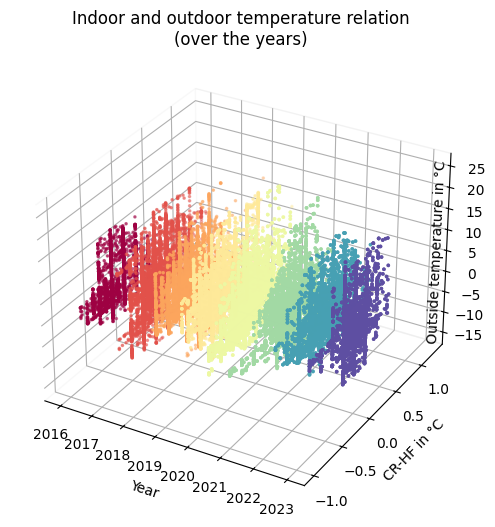

In [43]:
# Create scatter plot 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z, y, x, s=10, c=z, marker='.', cmap="Spectral")  #RdYlGn PiYG_r
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.fill = False
ax.set_zlabel('Outside temperature in °C', labelpad=-25)
ax.set_ylabel(y.name+' in °C')
ax.set_xlabel('Year  ')
ax.set_title('Indoor and outdoor temperature relation\n(over the years)')
#plt.tight_layout()
#plt.show()

### Step 12 - DRAFT

### Further analyses - #3 Cross Validation

Cross Validation in Time Series requires special attention to the temporal structure of the data  --> TSCV.
Generally we determine whether a given model is optimal by looking at it's F1, precision, recall, and accuracy (for classification), or it's coefficient of determination (R2) and error (for regression) --> R2.

> ARIMA models cannot handle any type of non-stationarity - therefore not used and commented out in code below

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

'''
# ARIMA model: Train-test split, train and predict 
from statsmodels.tsa.arima.model import ARIMA

# Prepare data
cn = ['CR-HF'] #, 'OG_W'
data = df[cn]#.astype(float) #df.iloc[:,c]  #c = CR-HF

#df_lr = pd.DataFrame({'y': df_lr.values})
debug = 0 
if debug:
    print(data.dtypes)
    print(data)
###df_lr['y'] = df_lr['AZ_Temp'] 

#standard notation is used of ARIMA(p,d,q)
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.
#lowest AIC score

print("ARIMA Model")
print("> Time series:")

# for time-series cross-validation set n_splits folds
tscv = TimeSeriesSplit(n_splits=7)

# Initialize lists to store evaluation metrics
mse_scores = []
 
# Iterate over train-test splits and train models
for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
 
    # Fit ARIMA model
    model = ARIMA(train_data, order=(3, 0, 1))  # Example order for ARIMA; autoregressive (AR) component, differencing (I) component, and moving average (MA) component
    fitted_model = model.fit()
 
    # Make predictions
    predictions = fitted_model.forecast(steps=len(test_data))
 
    # Calculate Mean Squared Error
    mse = mean_squared_error(test_data, predictions)
    mse_scores.append(mse)
 
    #print(f'Mean Squared Error for current split: {mse}')
print("CV Scores:", mse_scores)
# Calculate average Mean Squared Error across all splits
average_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error across all splits: {average_mse}')

'''

# Linear Regression model: Train-test split, train and predict 
from sklearn.model_selection import KFold

# Target value is first column
cn = ['CR-HF', 'OG_T', 'OA_TL']
data = df[cn]

# Normalize data
data = pd.DataFrame(preprocessing.normalize(data, norm="l1"), columns=data.columns)
print(data)

# Split df into independent variable...
X = data.drop(data.columns[0], axis=1)
# ...and into dependent variable
y = data[cn[0]]


# Define model and number of splits
model = linear_model.LinearRegression()
n_splits = 7

print("Cross Validations")
# Performing k-Fold Cross Validation (for curiosity)
print("> k-Fold:")
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42) 
scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print("  CV Scores (R2):", scores)
print("  Average:", scores.mean()) 

# Performing time-series Cross Validation
print("> Time series:")
tscv = TimeSeriesSplit(n_splits=n_splits)
scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
print("  CV Scores (R2):", scores)
print("  Average:", scores.mean()) 

'''
##### Test with "simple split" to plot it #####
test_size=(1/n_splits)
# Get the index after which test set starts
test_index = int(len(x)*(1-test_size))
print(test_index)
# Define train and holdout data
#X_train = X.iloc[:test_index] 
#y_train = y.iloc[:test_index]
#X_test = X.iloc[test_index:] 
#y_test = y.iloc[test_index:]#, 1] 
'''
# Model with split from TSCV above
n_samples = X.shape[0]
s = n_samples//(n_splits + 1)

X_train, X_test = X[ :-s], X[-s: ] # get last set
y_train, y_test = y[ :-s], y[-s: ] # get last set

# LinearRegression instance is fitted
model.fit(X_train, y_train) 

# Calculate prediction and print numbers
y_pred = model.predict(X_test)
print(f'\nLinear regression of ' + cn[0])
print('  The coefficient(s) are: {0}'.format(model.coef_))
print('  Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('  The intercept is: {0}'.format(model.intercept_))
print('  The coefficient of determination of the values is: {0}'.format(r2_score(y_test, y_pred)))

colour_style = "grayscale" #"tableau-colorblind10"

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    """
    
    y_pred = model.predict(X_test)

    with plt.style.context(colour_style):
        plt.figure(figsize=(15, 7))
        plt.plot(y_pred, "g", label="prediction", linewidth=1.0)
        plt.plot(y_test.values, label="actual", linewidth=2.0)
        
        if plot_intervals:
            cv = cross_val_score(model, X_train, y_train,
                                        cv=tscv,
                                        scoring="neg_mean_absolute_error")   #scoring= 'r2', 'neg_mean_squared_error', neg_mean_absolute_error
            mae = cv.mean() * (-1)
            deviation = cv.std()

            scale = 1.96
            lower = y_pred - (mae + scale * deviation)
            upper = y_pred + (mae + scale * deviation)

            plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
            plt.plot(upper, "r--", alpha=0.5)

            if plot_anomalies:
                anomalies = np.array([np.NaN]*len(y_test))
                anomalies[y_test<lower] = y_test[y_test<lower]
                anomalies[y_test>upper] = y_test[y_test>upper]
                plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

        error = mean_absolute_percentage_error(y_test, y_pred)          #use correct function 
        plt.title(str(cn[0])+" - Mean absolute percentage error: {0:.2f}%".format(error))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True, axis='y')

def plotCoefficients(trend):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(trend.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    with plt.style.context(colour_style):
        plt.figure(figsize=(15, 7))
        plt.title(str(cn[0])+" - Sorted coefficient values")
        coefs.coef.plot(kind='bar')
        plt.grid(True, axis='y')
        plt.hlines(y=0, xmin=-1, xmax=len(coefs), linestyles='dashed', color='k')

# Calculate prediction and visualize numbers
print('\nPlotting last instance of Cross Validation:')
plotModelResults(model) #, plot_intervals=True , plot_anomalies=True
plotCoefficients(model)   

### (optional) Ordinary Least Squares - DRAFT

In [ ]:
from statsmodels.formula.api import ols

cn = ['CR-HF', 'UTC'] #
df_short = df[cn]
df_short.index = df['UTC']

#t = range(df_short.index.size)
t = df_short.index
t
s = df_short.index.month.astype('int') #astype('category')
s

model = ols('df_short ~ t + s', data = df_short).fit()
model.summary()